## Fine-tuning GPT-2 for machine translation

In this notebook we will use the pre-train GPT-2 and fine-tune it (or re-train it) on translations from Spanish to English.

### The Dataset

First, we download the dataset from tensorflow

In [1]:
import tensorflow as tf

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    cache_dir=".", extract=True)

path_to_file = "datasets/spa-eng_extracted/spa-eng/spa.txt"

In [2]:
# !pip install datasets

The extracted file is in a txt format, but we can also load txt using the datasets library:

In [2]:
from datasets import load_dataset

dataset = load_dataset("text", data_files=path_to_file, split="train")
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 118964
})

We can observe that these translations are divided by a tabular. Also, the first examples are actually very short sentences.

In [3]:
dataset[0:10]

{'text': ['Go.\tVe.',
  'Go.\tVete.',
  'Go.\tVaya.',
  'Go.\tVáyase.',
  'Hi.\tHola.',
  'Run!\t¡Corre!',
  'Run.\tCorred.',
  'Who?\t¿Quién?',
  'Fire!\t¡Fuego!',
  'Fire!\t¡Incendio!']}

Somewhere in the middle we can start seeing more complex translations.

In [4]:
dataset[50000]["text"].split("\t")

['The place was almost empty.', 'El lugar estaba casi vacío.']

In [5]:
for d in dataset:
    if len(d["text"]) > 100:
        print(d["text"])
        break

I noticed he was wearing my slippers.	Me percaté de que llevaba puestas mis zapatillas de estar en casa.


We can inspect this distribution based on the length of all sentences.

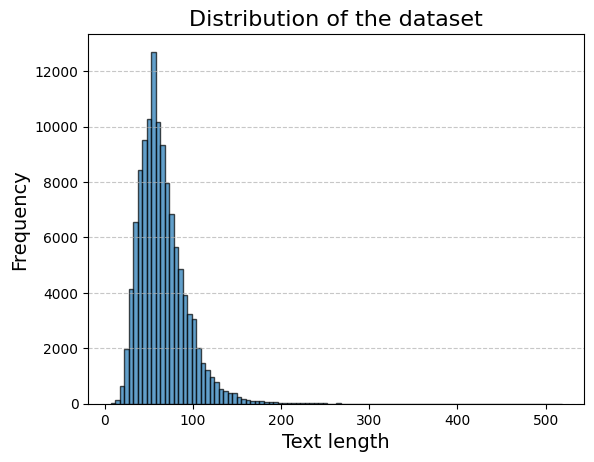

In [6]:
import matplotlib.pyplot as plt

string_lengths = [len(example["text"]) for example in dataset]

plt.hist(string_lengths, bins=100, edgecolor='black', alpha=0.7)
plt.title('Distribution of the dataset', fontsize=16)
plt.xlabel('Text length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


We are more insterested in sentences that are not too short and not too long.

### Pre-processing

We can use **filter()**, which returns rows that match a specified condition, to extract our wanted examples based on our length criteria.

In [7]:
filtered_dataset = dataset.filter(lambda x: len(x["text"]) > 50 and len(x["text"]) < 150)
filtered_dataset

Filter:   0%|          | 0/118964 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 80112
})

We shuffle the entire dataset.

In [8]:
shuffled_dataset = filtered_dataset.shuffle(seed=42)

Now, we can use **select()**, which returns rows according to a list of indices, to reduce the size of our dataset.

In [9]:
data_size = 12000
small_dataset = shuffled_dataset.select(range(data_size))
small_dataset

Dataset({
    features: ['text'],
    num_rows: 12000
})

Finally we generate our train and test splits.

In [10]:
dataset = small_dataset.train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 10800
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1200
    })
})

In [33]:
example = small_dataset[0]["text"].replace("\t", " ")
example

'How many close friends do you have? ¿Cuántos buenos amigos tienes?'

The last step involves tokenizing our dataset, so first we will separate the prompt and completions (eng and spa) for each example, and then we will concatenate them again and add the EOS token, so our model learns to only generate the translations and nothing else.

Also is very important to add the **[pad]** special token because we want to avoid using EOS as the PAD token.

In [1]:
from datasets import load_dataset

dataset = load_dataset("OscarNav/spa-eng")

In [2]:
dataset = dataset["train"].select(range(100))

In [3]:
dataset

Dataset({
    features: ['eng', 'spa'],
    num_rows: 100
})

In [4]:
from transformers import AutoTokenizer

checkpoint = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.add_special_tokens({"pad_token": "<pad>"})

def process(example):
    eng, spa = example["eng"], example["spa"]
    input_text = eng + " " + spa + tokenizer.eos_token
    example["text"] = input_text
    input_encodings = tokenizer(input_text, truncation=True)
    
    return {"eng": eng, "spa": spa,
            "input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"]}

In [5]:
tokenized_dataset = dataset.map(process, batched=False)
tokenized_dataset

Dataset({
    features: ['eng', 'spa', 'text', 'input_ids', 'attention_mask'],
    num_rows: 100
})

We can see how our examples are concatenated.

In [6]:
tokenized_dataset[0]

{'eng': 'When the curtain went up, the stage was dark.',
 'spa': 'Al levantarse el telón, la escena estaba oscura.',
 'text': 'When the curtain went up, the stage was dark. Al levantarse el telón, la escena estaba oscura.<|endoftext|>',
 'input_ids': [2215,
  262,
  29461,
  1816,
  510,
  11,
  262,
  3800,
  373,
  3223,
  13,
  978,
  443,
  4520,
  17208,
  1288,
  13632,
  18840,
  11,
  8591,
  3671,
  8107,
  2803,
  64,
  267,
  1416,
  5330,
  13,
  50256],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

### Training!!!

In [16]:
from huggingface_hub import login

login()

Before training, is important to add the PAD token to the model config and call the **resize_token_embeddings()** method and avoid out of index errors.

In [7]:
from transformers import AutoModelForCausalLM, DataCollatorForLanguageModeling
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = torch.device("cpu") # force CPU

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2").to(device)
model.config.pad_token_id = tokenizer.pad_token_id
#model.resize_token_embeddings(len(tokenizer))

repo_name = "gpt-2-finetuned-spa-eng"

In [9]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=repo_name,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    learning_rate=5e-4,
    num_train_epochs=3,
    logging_steps=100,
    save_steps=1e9, # no saving (local)
    overwrite_output_dir=True,
    use_cpu=device.type=="cpu",
    report_to="none",
    push_to_hub=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset
)

In [10]:
trainer.train()

Step,Training Loss
100,5.085600
200,2.704200
300,1.237900


TrainOutput(global_step=300, training_loss=3.0092705281575522, metrics={'train_runtime': 253.6839, 'train_samples_per_second': 1.183, 'train_steps_per_second': 1.183, 'total_flos': 3349845504000.0, 'train_loss': 3.0092705281575522, 'epoch': 3.0})

In [11]:
model.config

GPT2Config {
  "_name_or_path": "openai-community/gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 50257,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "float32",
  "transformers_version": "4.46.2",
  "use_cache": true,
  "vocab_size": 50257
}

In [12]:
input_text = "When the curtain went up, the stage was dark."
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
out = model.generate(input_ids, do_sample=True)
print(tokenizer.decode(out[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/home/oscarn/miniconda3/envs/transformers-311/lib/python3.11/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


When the curtain went up, the stage was dark. Para escritorio la telón la


In [13]:
input_text = "I am a student. I study at the university. I am learning to be a doctor."
input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=1000).to(device)
out = model.generate(input_ids, pad_token_id=tokenizer.pad_token_id, do_sample=True)
print(tokenizer.decode(out[0], skip_special_tokens=True))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


I am a student. I study at the university. I am learning to be a doctor.


In [17]:
# batch input
input_text = ["I am a student. I study at the university",
              "I am a teacher. I teach at the university"]
input_ids = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)
out = model.generate(input_ids["input_ids"], pad_token_id=tokenizer.pad_token_id, do_sample=True)
print(tokenizer.batch_decode(out, skip_special_tokens=True))

['I am a student. I study at the university of the University of the Philippines que detros de', 'I am a teacher. I teach at the university of lí crecioné tu nue']


In [24]:
# batch input
input_text = ["I am a student. I study at the university",
              "I am a teacher. I teach at the university"]
input_ids = tokenizer(input_text, return_tensors="pt", padding="max_length", max_length=2000).to(device)
out = model.generate(input_ids["input_ids"], pad_token_id=tokenizer.eos_token_id, do_sample=True)
print(tokenizer.batch_decode(out, skip_special_tokens=True))

/home/oscarn/miniconda3/envs/transformers-311/lib/python3.11/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


ValueError: Input length of input_ids is 2000, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.

In [22]:
input_ids

{'input_ids': tensor([[  40,  716,  257, 3710,   13,  314, 2050,  379,  262, 6403],
        [  40,  716,  257, 4701,   13,  314, 4545,  379,  262, 6403]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

#### We can load our checkpoint from the hub and test the quality of translations

In [21]:
model = AutoModelForCausalLM.from_pretrained("OscarNav/gpt-2-finetuned-spa-eng").to(device)

In [26]:
tokenized_dataset["train"][0]["text"]

'The sink is full of dirty dishes. El fregadero está lleno de platos sucios.<|endoftext|>'

In [37]:
input_text = "El fregadero"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
output = model.generate(input_ids, max_length=100, do_sample=True, pad_token_id=tokenizer.pad_token_id)
output_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(output_text)

El fregadero, the world knows more. El consejo del mundo, el mundo conocece más.


We can see that our model tries its best to finish the sentences (which in this case translate the given sentence)

The following function will help us to automate the generation process using random sampling as decoding strategy:

### Evaluating the model

In [30]:
from tqdm.auto import tqdm

def generate(input_list, return_full_text=True, max_tokens=200):
    outputs = []
    for input in tqdm(input_list, desc="Generating responses... "):
        inputs = tokenizer(input, return_tensors='pt').to(device)
        input_length = len(tokenizer.decode(inputs["input_ids"][0]))
        with torch.no_grad():
            output = tokenizer.decode(
                    model.generate(
                    inputs["input_ids"],
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.pad_token_id,
                    max_new_tokens=max_tokens,
                    do_sample=True
                )[0],
                skip_special_tokens=True
            )
        if return_full_text:
            outputs.append(output) # for sequence-to-sequence models
        else: 
            outputs.append(output[input_length:].strip()) # for models that generate the entire text at once (auto-regressive models)

    return outputs

First, let's generate the responses of our fine-tuned GPT-2 model.

In [31]:
gpt2_inputs = [example["eng"] for example in tokenized_dataset["test"]]
gpt2_responses = generate(gpt2_inputs, return_full_text=False)

Generating responses... :   0%|          | 0/1200 [00:00<?, ?it/s]

In [40]:
gpt2_responses

['¿No quieres quedarte aquí con nosotros?',
 'Ella apasionó los dedos sobre la mesa.',
 'La competencia es una mala en sí misma.',
 'Todavía no he leído todos los dos libros.',
 'De verdad estoy desocupado ahora mismo.',
 'Esta fruta tiene un olor desagradable.',
 '¿Has visto algunas películas últimamente?',
 'Me sentí un poco mal por Tom.',
 'Ayer me quedé en su casa.',
 'Le expliqué las reglas.',
 'Mi tío enseña inglés en una universidad.',
 'Tom ya no ama a Mary.',
 'No me puedo hacer entender en francés.',
 'Él no quiere que piernes una semana entera.',
 'Tom y Mary no están temblados de John.',
 'Mi tía me trajo como si fuera un niño.',
 '¿El libro era interesante?',
 '¿Cuánto cuesta el coche que tienes previsto comprar?',
 '¿Sabés en dónde se estaba escondiendo Tom?',
 'Quiero que todo esté perfecto.',
 'Yo come las bañas todas las mañanas en verano.',
 'Ninguno de ellos se conocen francés.',
 'Si no se ve ahora es cuando?',
 'Sin él, estaría desampado.',
 'Sé que tienes que en d

Now, we will use FLAN-T5 (a seq2seq language model) to compare the generations of our model. This model is finetuned on multiple tasks, so it is not directly trained on translations, so it's a fair comparison (as we only trained our model for a few epochs).

In [41]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

checkpoint = "google/flan-t5-base"

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint).to(device)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [24]:
flant5_inputs = [f"Translate English to Spanish: {example['eng']}" for example in tokenized_dataset["test"]]
flant5_responses = generate(flant5_inputs)

Generating responses... :   0%|          | 0/1200 [00:00<?, ?it/s]

In [25]:
flant5_responses

['No quieres habitar aqu con nosotros?',
 'He dejó por los nios sobre el cárcel.',
 'El concurso no es bad en su propio interior.',
 'No han odo yo luego todos estos libros.',
 'Se necesita el alcohol actualmente.',
 'Este fruta tiene olor unpleasant.',
 'Has visto algunas pelculas hoy?',
 'Elme sentido triste por Tom',
 'Mientras que vién en ella, tomando mi paseo.',
 'Yo yo explicé los reglamentos a ella.',
 'Mi hermano es quedade inglés en una instituto.',
 'Tom no me alegra Marán.',
 'No podra comprenderme francesa.',
 'No quiere que te perderes esta semana una vez.',
 'Tom y Mary no están tus amareles de juliano.',
 'Mi aunt me tremble lo que tengo sién cómo era.',
 'Italo fue interesante, tu?',
 'Cuánto es el coche que está destinando a comprar?',
 'Know dónde Tom estaba circunstancialmente ?',
 'Quizá que todo esto sea perfectamente real.',
 'As que te va a las habitaciones de los maanas.',
 'Ni mujeres none sabe francés.',
 'Si no actualmente, por qué?',
 'Sin él, jóvenes no se

In [42]:
references = [example["spa"] for example in tokenized_dataset["test"]]

In [43]:
import pandas as pd

df = pd.DataFrame({"reference": references, "flant5": flant5_responses, "gpt2": gpt2_responses})
df

,reference,flant5,gpt2
0,¿No quieres quedarte aquí con nosotros?,No quieres habitar aqu con nosotros?,¿No quieres quedarte aquí con nosotros?
1,Ella tamborileó con los dedos sobre la mesa.,He dejó por los nios sobre el cárcel.,Ella apasionó los dedos sobre la mesa.
2,La competencia en sí misma no es mala.,El concurso no es bad en su propio interior.,La competencia es una mala en sí misma.
3,Todavía no he leído todos estos libros.,No han odo yo luego todos estos libros.,Todavía no he leído todos los dos libros.
4,De verdad que necesito un trago ahora.,Se necesita el alcohol actualmente.,De verdad estoy desocupado ahora mismo.
...,...,...,...
1195,Es peligroso ir en moto sin casco.,Es peligroso atravesar a un motorbio sin cuerp...,Es peligroso viajar un coche sin callejero.
1196,Nubes oscuras son señal de lluvia.,Las opacas oscuras son al delante del mayo.,Nubes oscuras son una señal de lluvia.
1197,Se paró detrás de la silla.,Supositó bajo el trabajo.,Le estaba detrás de la silla.
1198,Creo que es importante distinguir claramente u...,Minun funciona de que distinguir la opinión de...,Creo que claramente diferente distinguir la op...


We can see that our model performs pretty good, almost outperforming FLAN-T5. But this is only a qualitative (human) evaluation. Let's crunch some numbers:

##### BLEU

In [44]:
# !pip install evaluate sacrebleu

In [45]:
import evaluate

bleu_metric = evaluate.load("sacrebleu")
score = bleu_metric.compute(references=references, predictions=gpt2_responses)["score"] / 100
print(f"GPT-2 BLEU score: {score}")

GPT-2 BLEU score: 0.5484472294750219


In [46]:
score = bleu_metric.compute(references=references, predictions=flant5_responses)["score"] / 100
print(f"FLAN-T5 BLEU score: {score}")

FLAN-T5 BLEU score: 0.10894504663040643


**Good enough, our model got a 50% of performance using this metris whereas FLAN-T5 only got 10%. This means that our training was succesful!!**